# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing as pre, impute, compose
from sklearn import dummy, linear_model as lm
from sklearn import model_selection as ms, pipeline as pl
from sklearn import metrics

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from bobs import prep, learn, plots
import components

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives
5. Applicants with fewer dependents they have to spend money on
6. Married applicants (proxy for age, and more stability)
7. Smaller amounts (it's easier to get a smaller loan!)
8. There might be combined married + gender + dependent effects because of traditional two-parent households where the mother stays home: marriage would *increase* stability for the stay-at-home mom, *decrease* stability for the working father.

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [2]:
loans = pd.read_csv("loans.csv")
loans.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
train, test = ms.train_test_split(loans)

In [4]:
target = 'Loan_Status'

In [5]:
x_train, y_train = prep.split_y(train, target)
x_test, y_test = prep.split_y(test, target)

One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [6]:
train.shape, test.shape

((460, 13), (154, 13))

In [7]:
train.isna().sum()

Loan_ID               0
Gender                9
Married               1
Dependents           10
Education             0
Self_Employed        26
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           14
Loan_Amount_Term     10
Credit_History       34
Property_Area         0
Loan_Status           0
dtype: int64

Look at some basic statistics for numerical variables.

In [8]:
train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,460.000000,460.000000,446.000000,450.000000,426.000000
mean,5344.621739,1552.271565,143.928251,341.733333,0.842723
std,5720.364455,2831.896987,86.296220,65.099821,0.364490
min,150.000000,0.000000,17.000000,12.000000,0.000000
25%,2875.750000,0.000000,100.000000,360.000000,1.000000
50%,3716.500000,1020.000000,125.000000,360.000000,1.000000
75%,5746.000000,2250.000000,161.000000,360.000000,1.000000
max,63337.000000,41667.000000,700.000000,480.000000,1.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



In [9]:
train.Credit_History.value_counts()

1.0    359
0.0     67
Name: Credit_History, dtype: int64

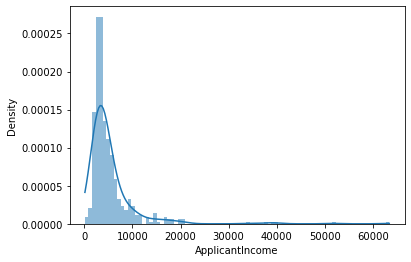

In [10]:
plots.distplot(train, 'ApplicantIncome')

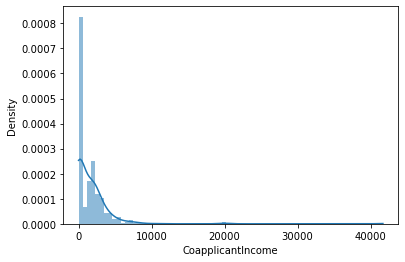

In [11]:
plots.distplot(train, 'CoapplicantIncome')

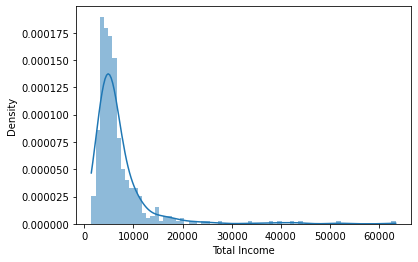

In [110]:
total_income = (train.ApplicantIncome + train.CoapplicantIncome).to_frame('TotalIncome')
plots.distplot(total_income, 'TotalIncome')
plt.xlabel('Total Income')
plt.savefig('income-raw.png', dpi=200)

In [13]:
train.ApplicantIncome.mean(), train.ApplicantIncome.median()

(5344.621739130434, 3716.5)

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [14]:
train.Gender.value_counts()

Male      371
Female     80
Name: Gender, dtype: int64

In [15]:
train.Married.value_counts()

Yes    291
No     168
Name: Married, dtype: int64

In [16]:
train.Education.value_counts()

Graduate        364
Not Graduate     96
Name: Education, dtype: int64

In [17]:
train.Self_Employed.value_counts()

No     375
Yes     59
Name: Self_Employed, dtype: int64

In [18]:
train.Property_Area.value_counts()

Semiurban    175
Urban        154
Rural        131
Name: Property_Area, dtype: int64

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

Should I make property area categorical or ordinal?

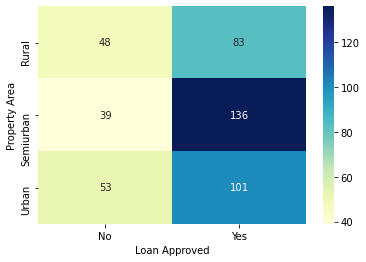

In [105]:
sns.heatmap(
    pd.crosstab(train.Property_Area, train.Loan_Status),
    cmap='YlGnBu', annot=True, fmt='d'
)
plt.xlabel('Loan Approved')
plt.xticks([0.5, 1.5], ['No', 'Yes'])
plt.ylabel('Property Area')
plt.savefig('property-area.png', dpi=200)
plt.show()

This suggests categorical, since it's the semiurban areas that favour loans the most. This may be a consequence of other variables, like wealth, but I don't want to miss potential effects here.

What about dependents?

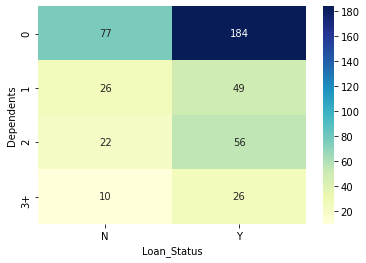

In [75]:
sns.heatmap(
    pd.crosstab(train.Dependents, train.Loan_Status),
    cmap='YlGnBu', annot=True, fmt='d'
)
plt.show()

Not much going on here. Seems pretty reasonable to just turn 3+ into 3 and make it ordinal.

### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



Look at box plots to understand the distributions. Look at the distribution of income segregated  by `Education`

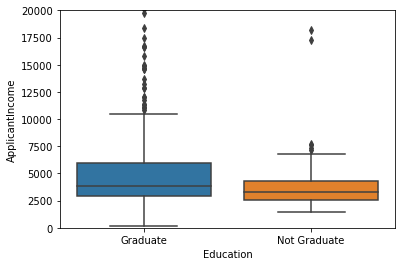

In [21]:
sns.boxplot(data=train, x='Education', y='ApplicantIncome')
plt.ylim(0, 20000)
plt.show()

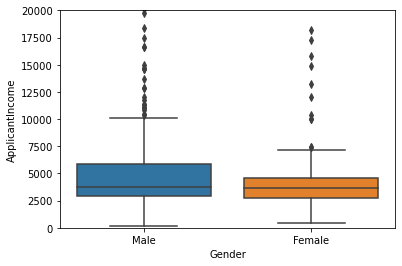

In [22]:
sns.boxplot(data=train, x='Gender', y='ApplicantIncome')
plt.ylim(0, 20000)
plt.show()

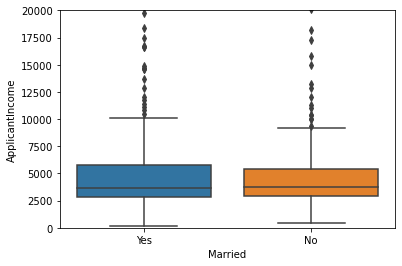

In [23]:
sns.boxplot(data=train, x='Married', y='ApplicantIncome')
plt.ylim(0, 20000)
plt.show()

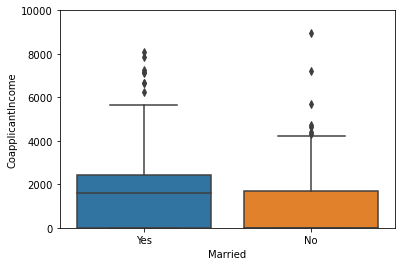

In [24]:
sns.boxplot(data=train, x='Married', y='CoapplicantIncome')
plt.ylim(0, 10000)
plt.show()

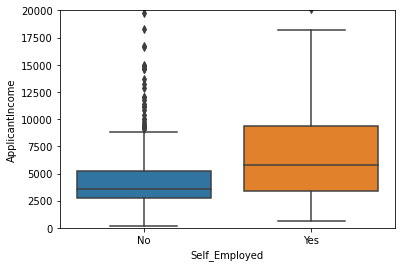

In [25]:
sns.boxplot(data=train, x='Self_Employed', y='ApplicantIncome')
plt.ylim(0, 20000)
plt.show()

Look at the histogram and boxplot of LoanAmount

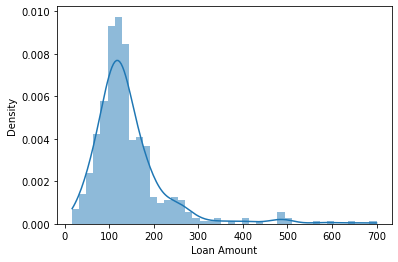

In [108]:
plots.distplot(train, 'LoanAmount')
plt.xlabel('Loan Amount')
plt.savefig('amount-raw.png', dpi=200)

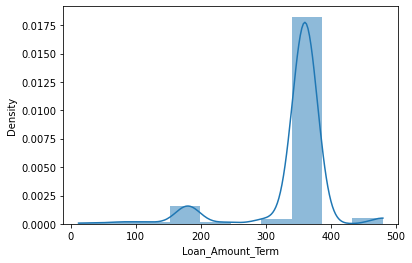

In [27]:
plots.distplot(train, 'Loan_Amount_Term')

In [28]:
train.Loan_Amount_Term.value_counts().sort_index()

12.0       1
36.0       1
60.0       1
84.0       3
120.0      3
180.0     34
240.0      3
300.0      9
360.0    384
480.0     11
Name: Loan_Amount_Term, dtype: int64

In [29]:
train[train.Loan_Amount_Term <= 120].Loan_Status.value_counts()

Y    7
N    2
Name: Loan_Status, dtype: int64

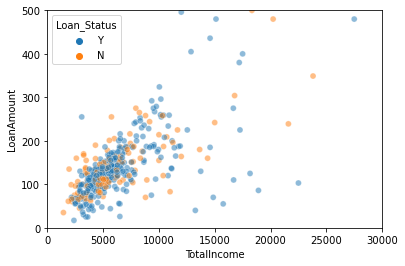

In [30]:
sns.scatterplot(
    x=total_income.TotalIncome, y=train.LoanAmount, hue=train.Loan_Status, alpha=0.5
)
plt.xlim(0, 30000)
plt.ylim(0, 500)
plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [31]:
train.pivot_table(
    values='ApplicantIncome', index=['Gender', 'Married', 'Dependents'],
    aggfunc=['mean', 'count']
)

mean           count
                          ApplicantIncome ApplicantIncome
Gender Married Dependents                                
Female No      0              5066.024390              41
               1              5033.000000              10
               2              3588.500000               2
               3+             1776.333333               3
       Yes     0              3544.062500              16
               1              8333.000000               2
               2              5639.500000               4
Male   No      0              4904.910112              89
               1              7787.100000              10
               2              4127.600000               5
               3+             6937.000000               2
       Yes     0              5311.963303             109
               1              5719.056604              53
               2              5144.939394              66
               3+             6066.068966              29

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [32]:
imputations = [
    (
        'categorical', impute.SimpleImputer(strategy='most_frequent'),
        ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term']
    ),
    (
        'credit', impute.SimpleImputer(strategy='constant', fill_value=0),
        ['Credit_History']
    )
]

In [33]:
partial_imputer = compose.ColumnTransformer(
    imputations, remainder='passthrough'
)

In [34]:
train_imputed = partial_imputer.fit_transform(train)

In [35]:
pd.DataFrame(train_imputed).isna().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10    14
11     0
12     0
dtype: int64

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

In [36]:
loan_boxcox = pre.PowerTransformer(method='box-cox')

In [37]:
train_loan_boxcox = pd.DataFrame(
    loan_boxcox.fit_transform(train[['LoanAmount']]),
    columns=['LoanAmountTransformed']
)

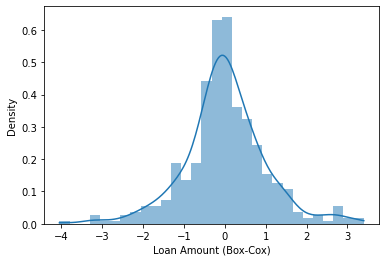

In [109]:
plots.distplot(train_loan_boxcox, 'LoanAmountTransformed')
plt.xlabel('Loan Amount (Box-Cox)')
plt.savefig('amount-transformed.png', dpi=200)

Combine both incomes as total income and take a log transformation of the same.

In [39]:
total_income_maker = pre.FunctionTransformer(components.combine_income)

In [40]:
total_income_boxcox = pre.PowerTransformer(method='box-cox')

In [41]:
total_income_pipeline = pl.Pipeline([
    ('maker', total_income_maker),
    ('boxcox', total_income_boxcox),
])

In [42]:
train_total_income_boxcox = pd.DataFrame(
    total_income_pipeline.fit_transform(
        train[['ApplicantIncome', 'CoapplicantIncome']]
    ),
    columns=['TotalIncomeTransformed']
)

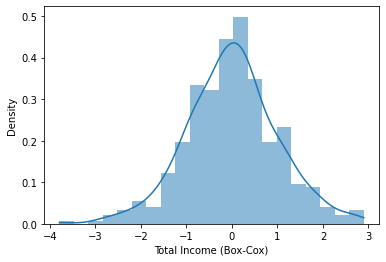

In [111]:
plots.distplot(train_total_income_boxcox, 'TotalIncomeTransformed')
plt.xlabel('Total Income (Box-Cox)')
plt.savefig('income-transformed.png', dpi=200)

### Putting these together in the column transformer

In [44]:
loan_clean = pl.Pipeline([
    ('impute', impute.SimpleImputer()),
    ('boxcox', loan_boxcox)
])

In [45]:
income_clean = pl.Pipeline([
    ('impute', impute.SimpleImputer()),
    ('columns', prep.ColumnAssigner(['ApplicantIncome', 'CoapplicantIncome'])),
    ('total', total_income_maker),
    ('boxcox', total_income_boxcox),
])

In [46]:
cleaner = compose.ColumnTransformer(imputations + [
    ('amount', loan_clean, ['LoanAmount']),
    ('income', income_clean, ['ApplicantIncome', 'CoapplicantIncome']),
], remainder='passthrough')

In [47]:
cleaner_columns = [
    'Gender', 'Married', 'Dependents', 'SelfEmployed',
    'LoanAmountTerm', 'CreditHistory',
    'LoanAmountLog', 'TotalIncomeLog',
    'LoanID', 'Education', 'PropertyArea',
]

In [48]:
cleaner_recolumn = prep.ColumnAssigner(cleaner_columns)

In [49]:
x_cleaned = pd.DataFrame(cleaner.fit_transform(x_train), columns=cleaner_columns)

In [50]:
x_cleaned

,Gender,Married,Dependents,SelfEmployed,LoanAmountTerm,CreditHistory,LoanAmountLog,TotalIncomeLog,LoanID,Education,PropertyArea
0,Male,Yes,0,No,360,1,-0.483347,-0.942618,LP002361,Graduate,Urban
1,Male,Yes,0,No,360,1,-0.199629,0.255414,LP001041,Graduate,Urban
2,Female,No,0,Yes,360,1,-0.0303737,1.86582,LP002731,Not Graduate,Urban
3,Male,No,2,No,360,0,-0.936372,-0.936946,LP002545,Graduate,Rural
4,Male,No,0,No,360,0,1.31036,1.64278,LP001492,Graduate,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
455,Male,Yes,0,No,360,1,0.185109,0.0486478,LP001936,Graduate,Rural
456,Male,Yes,1,No,360,1,0.199659,-0.17307,LP001778,Graduate,Semiurban
457,Female,No,0,No,360,1,-0.113237,-0.419936,LP001692,Not Graduate,Semiurban
458,Male,Yes,0,No,180,1,-1.6606,0.350904,LP002928,Graduate,Semiurban


### Numerical encoding

In [51]:
onehot = pre.OneHotEncoder(
    drop='if_binary',
    categories=[
        ['Female', 'Male'],
        ['No', 'Yes'],
        ['No', 'Yes'],
        ['Not Graduate', 'Graduate'],
        ['Rural', 'Semiurban', 'Urban']
    ]
)

In [52]:
categorical = compose.ColumnTransformer([
    (
        'onehot', onehot,
        ['Gender', 'Married', 'SelfEmployed', 'Education', 'PropertyArea'],
    ),
    (
        'dependents', pre.OrdinalEncoder(categories=[['0', '1', '2', '3+']]),
        ['Dependents'],
    ),
], remainder='passthrough')

In [53]:
categorical_columns = [
    'Male', 'Married', 'SelfEmployed', 'Graduate',
    'Rural', 'Semiurban', 'Urban', 'Dependents',
    'LoanAmountTerm', 'CreditHistory', 'LoanAmountLog', 'TotalIncomeLog', 'LoanID',
]

In [54]:
categorical_recolumn = prep.ColumnAssigner(categorical_columns)

In [77]:
x_coded = pd.DataFrame(categorical.fit_transform(x_cleaned), columns=categorical_columns)

In [101]:
x_coded

,Male,Married,SelfEmployed,Graduate,Rural,Semiurban,Urban,Dependents,LoanAmountTerm,CreditHistory,LoanAmountLog,TotalIncomeLog,LoanID
0,1,1,0,1,0,0,1,0,360,1,-0.483347,-0.942618,LP002361
1,1,1,0,1,0,0,1,0,360,1,-0.199629,0.255414,LP001041
2,0,0,1,0,0,0,1,0,360,1,-0.0303737,1.86582,LP002731
3,1,0,0,1,1,0,0,2,360,0,-0.936372,-0.936946,LP002545
4,1,0,0,1,0,1,0,0,360,0,1.31036,1.64278,LP001492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,1,1,0,1,1,0,0,0,360,1,0.185109,0.0486478,LP001936
456,1,1,0,1,0,1,0,1,360,1,0.199659,-0.17307,LP001778
457,0,0,0,0,0,1,0,0,360,1,-0.113237,-0.419936,LP001692
458,1,1,0,1,0,1,0,0,180,1,-1.6606,0.350904,LP002928


## 4. Building a Predictive Model

In [56]:
labels = ['Y', 'N']

In [128]:
def validate(model):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)
    classes = model.classes_
    plots.confusionplot(y_test, y_pred, labels)
    plt.show()
    log_loss = metrics.log_loss(y_test, y_pred_proba, labels=classes)
    print(f"Log loss: {log_loss:.3g}")

In [58]:
def train_baseline():
    clf = dummy.DummyClassifier(strategy='prior')
    baseline_model = pl.Pipeline([
        ('classifier', clf)
    ])
    baseline_model.fit(x_train, y_train)
    return baseline_model

In [59]:
baseline = learn.load_or_train('baseline.pkl', train_baseline)

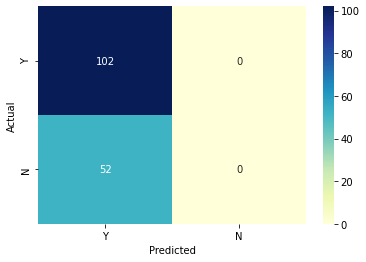

Log loss: 0.642


In [129]:
validate(baseline)

In [61]:
main_steps = [
    ('clean', cleaner),
    ('clean_columns', cleaner_recolumn),
    ('categorical', categorical),
    ('categorical_columns', categorical_recolumn),
    # Then append column selection/feature engineering
]

In [62]:
def train_amount_logistic():
    clf = lm.LogisticRegression(class_weight='balanced')
    scaler = pre.StandardScaler()
    model = pl.Pipeline(main_steps + [
        ('choose', prep.ColumnKeeper(['TotalIncomeLog', 'LoanAmountLog'])),
        ('scale', scaler),
        ('classify', clf),
    ])
    model.fit(x_train, y_train.values.ravel())
    return model

In [64]:
amount_logistic = learn.load_or_train('amount_logistic.pkl', train_amount_logistic)

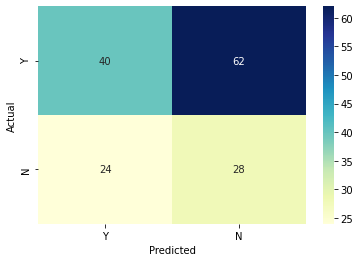

Log loss: 0.713


In [130]:
validate(amount_logistic)

In [66]:
def train_everything_logistic():
    clf = lm.LogisticRegression(class_weight='balanced')
    scaler = pre.StandardScaler()
    model = pl.Pipeline(main_steps + [
        ('choose', prep.ColumnDropper(['LoanID'])),
        ('scale', scaler),
        ('classify', clf),
    ])
    model.fit(x_train, y_train.values.ravel())
    return model

In [67]:
everything_logistic = learn.load_or_train(
    'everything_logistic.pkl', train_everything_logistic
)

In [132]:
everything_logistic.predict_proba(x_test)

array([[0.31581161, 0.68418839],
       [0.33762125, 0.66237875],
       [0.36229953, 0.63770047],
       [0.24915115, 0.75084885],
       [0.32314524, 0.67685476],
       [0.88654966, 0.11345034],
       [0.16274586, 0.83725414],
       [0.34351362, 0.65648638],
       [0.54342178, 0.45657822],
       [0.26433563, 0.73566437],
       [0.36803961, 0.63196039],
       [0.85643333, 0.14356667],
       [0.37449212, 0.62550788],
       [0.58635875, 0.41364125],
       [0.4224174 , 0.5775826 ],
       [0.51796665, 0.48203335],
       [0.1965542 , 0.8034458 ],
       [0.3240823 , 0.6759177 ],
       [0.20507148, 0.79492852],
       [0.40266809, 0.59733191],
       [0.16717921, 0.83282079],
       [0.72687532, 0.27312468],
       [0.32006148, 0.67993852],
       [0.47275356, 0.52724644],
       [0.90021944, 0.09978056],
       [0.41581732, 0.58418268],
       [0.78594899, 0.21405101],
       [0.72151196, 0.27848804],
       [0.22356376, 0.77643624],
       [0.27880889, 0.72119111],
       [0.

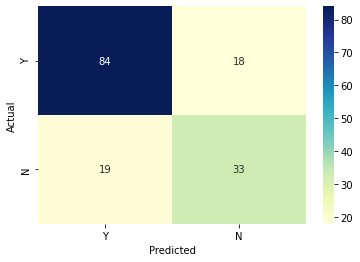

Log loss: 0.601


In [131]:
validate(everything_logistic)

In [69]:
{
    feature: coef for feature, coef
    in zip(categorical_columns, everything_logistic.named_steps['classify'].coef_[0])
}

{'Male': -0.014901579882740748,
 'Married': 0.2691478069775569,
 'SelfEmployed': -0.0614581694726902,
 'Graduate': 0.10179408716716336,
 'Rural': -0.1188217314349409,
 'Semiurban': 0.21289945531981247,
 'Urban': -0.10539159885588523,
 'Dependents': 0.006670847529750653,
 'LoanAmountTerm': -0.07245847396746653,
 'CreditHistory': 0.9069048814094327,
 'LoanAmountLog': -0.4697459514217498,
 'TotalIncomeLog': 0.3045447863908801}

Try paramater grid search to improve the results

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python